# WLS-EV Analysis

In [1]:
"""
KIT CRAM Seminar WS17/18
Algorithmic Design - Least squares estimates weighted by ex-ante return variance (WLS-EV)
"""

__author__ = 'Tobias Kuhlmann'

# Import own libraries
from wlsev.variance_estimation import ExAnteVariance
from wlsev.wlsev_model import Wlsev_model
from wlsev.ols_model import OLS_model
from tools.visualisation import plot_results, plot_scatter, plot_results_custom, plot_scatter_custom
# import general packages
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline


/Users/tobias/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Preprocessing

### Read in log return data and variance

### Log returns

In [2]:
# Import price data and calc log returns
# --------------------------------------------------
es_50_prices = pd.read_csv('data/eurostoxx50_prices_eod.csv', parse_dates=True)
# set index, rename and check
es_50_prices['loctimestamp'] =pd.to_datetime(es_50_prices['loctimestamp'])
es_50_prices = es_50_prices.rename(columns={'loctimestamp': 'date'})
es_50_prices = es_50_prices.set_index('date')

#Log Returns
es_50_logret = es_50_prices
es_50_logret['logreturns'] = (np.log(es_50_prices['lastprice'] / es_50_prices['lastprice'].shift(1))).dropna()

del es_50_logret['lastprice']

### Volatility data: old version of Simons file, new calculation in P-moments

In [3]:
# Import vol data
# --------------------------------------------------
es_50_vol = pd.read_csv('data/es50_volatility.csv', parse_dates=True)
# Transform dates
es_50_vol['loctimestamp'] = pd.to_datetime(es_50_vol['loctimestamp'])
# Delete unnecessary columns
del es_50_vol['instrumentid']
# Calculate variance from vol
es_50_vol['variance'] = es_50_vol['volatility'] ** 2
del es_50_vol['volatility']
# set index, rename and check
es_50_vol = es_50_vol.rename(columns={'loctimestamp': 'date'})
es_50_vol = es_50_vol.set_index('date')


### Implied volatility data: old version of Simons file, new calculation in Q-moments

In [4]:
# Import implied volatility
# --------------------------------------------------
es_50_imp_vol = pd.read_csv('data/es50_implied_volatility.csv', parse_dates=True)
# Transform dates
es_50_imp_vol['loctimestamp'] = pd.to_datetime(es_50_imp_vol['loctimestamp'])
# Delete unnecessary columns
del es_50_imp_vol['instrumentid']
del es_50_imp_vol['maturity']
# Calculate implied variance from implied vol
es_50_imp_vol['implied_var'] = es_50_imp_vol['measure'] ** 2
del es_50_imp_vol['measure']
# set index, rename and check
es_50_imp_vol = es_50_imp_vol.rename(columns={'loctimestamp': 'date'})
es_50_imp_vol = es_50_imp_vol.set_index('date')

### Riskfree rate

In [5]:
# Import riskfree rate data
# --------------------------------------------------
rf = pd.read_csv('data/riskfree_rate.csv', parse_dates=True, sep=';')
# Transform dates
rf['loctimestamp'] = pd.to_datetime(rf['loctimestamp'])
# set index, rename and check
rf = rf.rename(columns={'loctimestamp': 'date'})
rf = rf.set_index('date')

print(rf.head())
print(rf.tail())

            daystomaturity  riskfree
date                                
2002-01-02               7  0.033050
2002-01-02              30  0.032725
2002-01-02              60  0.032289
2002-01-02              91  0.032200
2002-01-02             182  0.031575
            daystomaturity  riskfree
date                                
2015-06-30             365 -0.001250
2015-06-30             547 -0.001230
2015-06-30             730 -0.001030
2015-06-30             912 -0.000685
2015-06-30            1095 -0.000340


### VRP data

In [6]:
# Import VRP data
# --------------------------------------------------
es_50_vrp = pd.read_csv('data/eurostoxx50_vrp.csv', parse_dates=True, sep=';')
# Transform dates
es_50_vrp['loctimestamp'] = pd.to_datetime(es_50_vrp['loctimestamp'])
# set index, rename and check
es_50_vrp = es_50_vrp.rename(columns={'loctimestamp': 'date'})
es_50_vrp = es_50_vrp.set_index('date')

### ERP data

In [7]:
# Calculate ERP from logrets and riskfree rate
# Take risk free rate maturity 7 (smallest maturity)
rf_mat7 = rf[rf['daystomaturity'] == 7].shift(-1) / 252
# Calculate ERP = logrets - rf
es_50_erp = pd.DataFrame({'erp': (es_50_logret['logreturns'] - rf_mat7['riskfree']).dropna()})

### Q-Moments data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10a6e34a8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x109e0ccc0>], dtype=object)

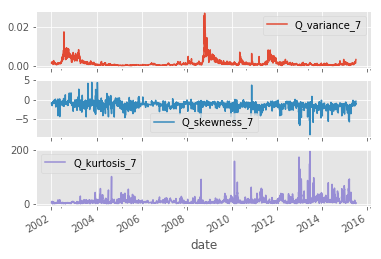

In [8]:
# Import Q-Moments data
# --------------------------------------------------
es_50_q = pd.read_csv('data/FiglewskiStandardizationEOD_DE0009652396D1_Qmoments.csv', parse_dates=True, sep = ';')
es_50_q.head(5)
# Transform dates
es_50_q['loctimestamp'] = pd.to_datetime(es_50_q['loctimestamp'])
# set index, rename and check
es_50_q = es_50_q.rename(columns={'loctimestamp': 'date'})
es_50_q = es_50_q.set_index('date')

# Delete unnecessary columns
del es_50_q['underlyingprice']
del es_50_q['underlyingforwardprice']
del es_50_q['Q_cubic']
del es_50_q['Q_quartic']

# Split maturities into seperate columns
es_50_q_7 = es_50_q[es_50_q['daystomaturity'] == 7]
es_50_q_7 = es_50_q_7.rename(columns={'Q_variance': 'Q_variance_7', 'Q_skewness': 'Q_skewness_7', 'Q_kurtosis': 'Q_kurtosis_7'})
del es_50_q_7['daystomaturity']

es_50_q_30 = es_50_q[es_50_q['daystomaturity'] == 30]
es_50_q_30 = es_50_q_30.rename(columns={'Q_variance': 'Q_variance_30', 'Q_skewness': 'Q_skewness_30', 'Q_kurtosis': 'Q_kurtosis_30'})
del es_50_q_30['daystomaturity']
# define 30 day maturity as implied vol
es_50_imp_vol = es_50_q_30['Q_variance_30']

es_50_q_60 = es_50_q[es_50_q['daystomaturity'] == 60]
es_50_q_60 = es_50_q_60.rename(columns={'Q_variance': 'Q_variance_60', 'Q_skewness': 'Q_skewness_60', 'Q_kurtosis': 'Q_kurtosis_60'})
del es_50_q_60['daystomaturity']

es_50_q_91 = es_50_q[es_50_q['daystomaturity'] == 91]
es_50_q_91 = es_50_q_91.rename(columns={'Q_variance': 'Q_variance_91', 'Q_skewness': 'Q_skewness_91', 'Q_kurtosis': 'Q_kurtosis_91'})
del es_50_q_91['daystomaturity']

es_50_q_182 = es_50_q[es_50_q['daystomaturity'] == 182]
es_50_q_182 = es_50_q_182.rename(columns={'Q_variance': 'Q_variance_182', 'Q_skewness': 'Q_skewness_182', 'Q_kurtosis': 'Q_kurtosis_182'})
del es_50_q_182['daystomaturity']

es_50_q_365 = es_50_q[es_50_q['daystomaturity'] == 365]
es_50_q_365 = es_50_q_365.rename(columns={'Q_variance': 'Q_variance_365', 'Q_skewness': 'Q_skewness_365', 'Q_kurtosis': 'Q_kurtosis_365'})
del es_50_q_365['daystomaturity']

es_50_q_7.plot(subplots = True)

### P-Moments data including return variance

In [9]:
# Import 5 min price data and calc log returns
# --------------------------------------------------
es_50_prices_5 = pd.read_csv('data/eurostoxx50_prices_5m.csv', parse_dates=True, sep=';')
# set index, rename and check
es_50_prices_5 = es_50_prices_5.rename(columns={'loctimestamp': 'date'})
es_50_prices_5['date'] = pd.to_datetime(es_50_prices_5['date'], errors='coerce')
es_50_prices_5 = es_50_prices_5.set_index('date')

#Log Returns
es_50_logret_5 = es_50_prices_5
es_50_logret_5['logreturns5min'] = np.log(es_50_prices_5['price'] / es_50_prices_5['price'].shift(1))
es_50_logret_5 = es_50_logret_5.dropna()

# Count of values per day
N = (es_50_logret_5.loc[(es_50_logret_5.index >= '2004-07-04 00:00:00') & (es_50_logret_5.index <= '2004-07-06 00:00:00')]).shape[0]

# Calculate moments after Amaya, Christoffersen, Jacobs, Vasquez (2015) - Does realized skewness predict equity returns
es_50_logret_5['logreturns_pow2'] = es_50_logret_5['logreturns5min'] ** 2
es_50_logret_5['logreturns_pow3'] = es_50_logret_5['logreturns5min'] ** 3
es_50_logret_5['logreturns_pow4'] = es_50_logret_5['logreturns5min'] ** 4

# group by date and sum up
helper = es_50_logret_5.groupby(es_50_logret_5.index.date).sum()

# Var 1 day = sum of intraday squared returns
es_50_P_1 = pd.DataFrame({'var1': helper['logreturns_pow2']})
# Skewness daily and variance of skewness: Var(x) = E_t[x^2] - E^2[x]
es_50_P_1['skewness1'] = helper['logreturns_pow3']
es_50_P_1['var_skewness1'] = es_50_logret_5['logreturns_pow3'].groupby(es_50_logret_5.index.date).var()
#es_50_P_1['var_skewness1'] = es_50_P_1['skewness1'] #- np.mean(es_50_P_1['skewness1']) ** 2
# Kurtosis daily and variance of kurtosis: Var(x) = E_t[x^2] - E^2[x]
es_50_P_1['kurtosis1'] = helper['logreturns_pow4']
es_50_P_1['var_kurtosis1'] = es_50_logret_5['logreturns_pow4'].groupby(es_50_logret_5.index.date).var()
#es_50_P_1['var_kurtosis1'] = es_50_P_1['kurtosis1'] ** 2 #- np.mean(es_50_P_1['kurtosis1']) ** 2

/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tobias/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

### Fama-French data

In [10]:
# Import Fama French Factors
# --------------------------------------------------
# HML and SMB
es_50_ff = pd.read_csv('data/FamaFrench_Europe_3_Factors_Daily.csv', parse_dates=True, skiprows=6)
es_50_ff = es_50_ff.rename(columns={'Unnamed: 0': 'date'})
es_50_ff['date'] = pd.to_datetime(es_50_ff['date'], format = '%Y%m%d')
es_50_ff = es_50_ff.set_index('date')

# Momentum Factor
es_50_ff2 = pd.read_csv('data/FamaFrench_Europe_MOM_Factor_Daily.csv', parse_dates=True, skiprows=6)
es_50_ff2 = es_50_ff2.rename(columns={'Unnamed: 0': 'date'})
es_50_ff2['date'] = pd.to_datetime(es_50_ff2['date'], format = '%Y%m%d')
es_50_ff2 = es_50_ff2.set_index('date')

# Join and drop na's
es_50_ff = es_50_ff.join(es_50_ff2).dropna()

## Join data for correct dates

In [11]:
# Join data
data_vrperp = pd.concat([es_50_logret, es_50_vol, es_50_imp_vol, es_50_vrp, es_50_erp], join='inner', axis=1).dropna()
data_retvol = pd.concat([es_50_logret, es_50_vol], join='inner', axis=1).dropna()
data_retimpvol = pd.concat([es_50_logret, es_50_vol], join='inner', axis=1).dropna()
data_qff = pd.concat([es_50_q_7, es_50_q_30, es_50_q_60, es_50_q_91, es_50_q_182, es_50_q_365, es_50_ff], join='inner', axis=1).dropna()
data_pq = pd.concat([es_50_q_7, es_50_q_30, es_50_q_60, es_50_q_91, es_50_q_182, es_50_q_365, es_50_P_1], join='inner', axis=1).dropna()

#data_wop.plot(subplots=True)
print(data_vrperp.shape)
print(data_retvol.shape)
print(data_retimpvol.shape)
print(data_qff.shape)
print(data_pq.shape)

(2962, 5)
(3815, 2)
(3815, 2)
(2713, 23)
(2713, 23)


# Visualisation

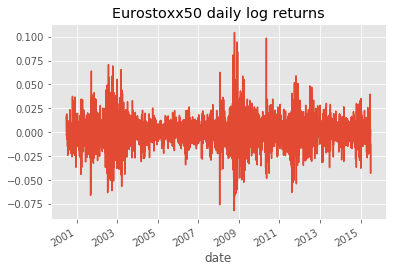

In [12]:
# log return plot
plt = data_retvol['logreturns'].plot(title='Eurostoxx50 daily log returns')
# get figure to save
plt = plt.get_figure()
plt.savefig('../Presentation/figures/euro50_logreturns.png')


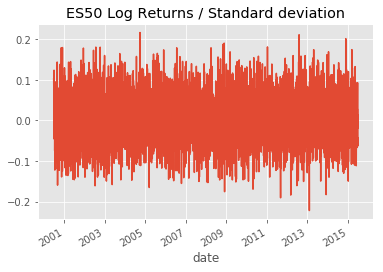

In [13]:
# log return plot
plt = (data_retvol['logreturns'] / data_retvol['variance'] ** 0.5).plot(title='ES50 Log Returns / Standard deviation')
# get figure to save
plt = plt.get_figure()
plt.savefig('../Presentation/figures/euro50_logstandard.png')


Index(['Q_variance_7', 'Q_skewness_7', 'Q_kurtosis_7', 'Q_variance_30',
       'Q_skewness_30', 'Q_kurtosis_30', 'Q_variance_60', 'Q_skewness_60',
       'Q_kurtosis_60', 'Q_variance_91', 'Q_skewness_91', 'Q_kurtosis_91',
       'Q_variance_182', 'Q_skewness_182', 'Q_kurtosis_182', 'Q_variance_365',
       'Q_skewness_365', 'Q_kurtosis_365', 'var1', 'skewness1',
       'var_skewness1', 'kurtosis1', 'var_kurtosis1'],
      dtype='object')


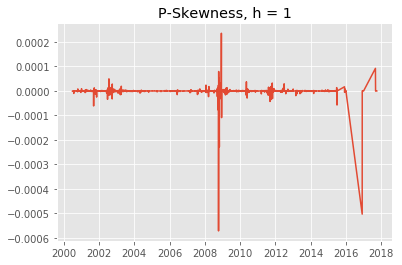

In [14]:
# P Moment plot
print(data_pq.columns)
plt = es_50_P_1['skewness1'].plot(title='P-Skewness, h = 1')
# get figure to save
plt = plt.get_figure()
plt.savefig('../Presentation/figures/p_skewness_1.png')

# Model and Analysis

## Estimate Ex ante Variance

In [15]:
# Model and Analysis
# ==================================================
#
# 1. Estimate (sigma_t)2, the (ex ante) conditional variance of next-period unexpected returns epsilon_(t+1)
# using a HAR-RV (Hierachical Autoregressive-Realized Variance) Model from Corsi (2009)
# ------------------------------------------------------------------------------------------------------------
# Log return variance
# ------------------------------------------------------------------------------------------------------------
ea_var_obj = ExAnteVariance(data_retvol['variance']) # no implied vol
#ea_var_obj = ExAnteVariance(data_wop['variance'], data_wop['implied_var']) # implied vol
result = ea_var_obj.estimate_variance() # Estimate Variance
# Join returns and estimated variance
# for return on return regression
data_retvol_var = data_retvol.join(pd.DataFrame({'var_logret_daily_est': result}).dropna()).dropna() # merge for correct indexing
# for erp on vrp regression
data_vrperp_var = data_vrperp.join(pd.DataFrame({'var_logret_daily_est': result}).dropna()).dropna() # merge for correct indexing


# P Moments variances for different maturities / forecast horizons
# ------------------------------------------------------------------------------------------------------------
ea_var_obj_skewness1 = ExAnteVariance(data_pq['var_skewness1']) 
result_skewness1 = ea_var_obj_skewness1.estimate_variance() # Estimate Variance
ea_var_obj_kurtosis1 = ExAnteVariance(data_pq['var_kurtosis1']) 
result_kurtosis1 = ea_var_obj_kurtosis1.estimate_variance() # Estimate Variance

# Join returns and estimated variance
result_variances = pd.DataFrame({'var_est_skewness1': result_skewness1, 'var_est_kurtosis1': result_kurtosis1
                 }).dropna()
data_pq_var = data_pq.join(result_variances).dropna() # merge for correct indexing

# Fama French Factor variances for different maturities / forecast horizons
# ------------------------------------------------------------------------------------------------------------

Variance Estimation Object initialized!
Variance Estimation begins!
Variance Estimation Results
                            OLS Regression Results                            
Dep. Variable:          var_daily_est   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2598.
Date:                Fri, 30 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:43:00   Log-Likelihood:                -3378.2
No. Observations:                3793   AIC:                             6764.
Df Residuals:                    3789   BIC:                             6789.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

### Visualisation of Skewness and Kurtosis standardization with ex ante variance

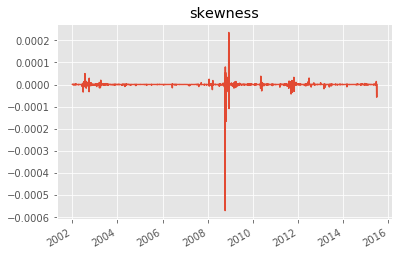

In [16]:
# skewness plot
(data_pq['skewness1']).plot(title='skewness')

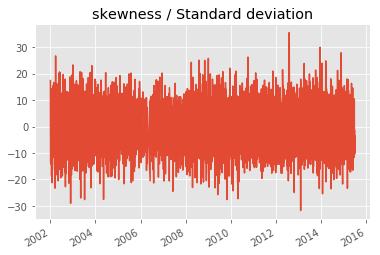

In [17]:
# standardized skewness
(data_pq['skewness1'] / data_pq['var_skewness1'] ** 0.5).plot(title='skewness / Standard deviation')

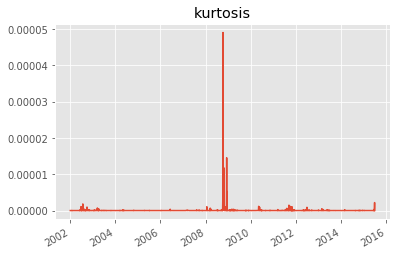

In [18]:
# kurtosis
(data_pq['kurtosis1']).plot(title='kurtosis')

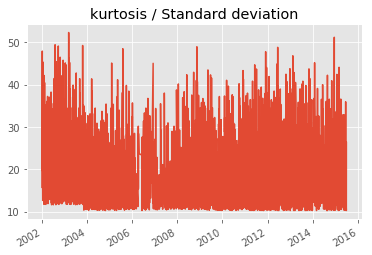

In [19]:
# standardized kurtosis
(data_pq['kurtosis1'] / data_pq['var_kurtosis1'] ** 0.5).plot(title='kurtosis / Standard deviation')

## WLS-EV and benchmark estimations

### Regress returns on returns

##### Forecast horizon 1,22,44, 66, 88

WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.00012855 -0.03451853]
robust bse standard errors: [ 0.00016991  0.01520178]
t-stats: [-0.75655599 -2.27068941]
In sample R_squared: 0.00134966
In sample R_squared of standardized regression: 0.00122084
Out of sample R_squared: 0.00319958
-------------------------------------------------------------------------------------------------------


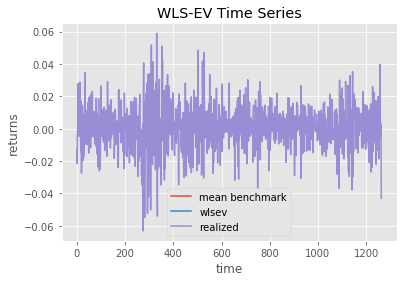

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.00010607 -0.03687895]
robust bse standard errors: [ 0.00022844  0.02022506]
t-stats: [-0.46432771 -1.82342822]
In sample R_squared: 0.00135744
Out of sample R_squared: 0.0033154
-------------------------------------------------------------------------------------------------------


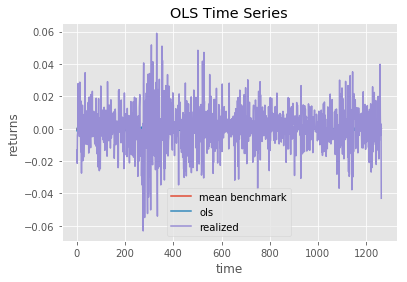

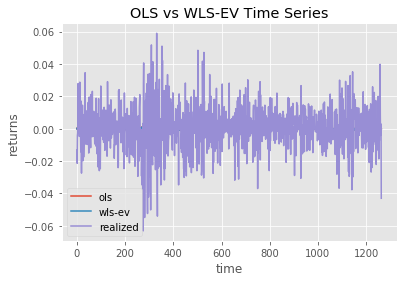

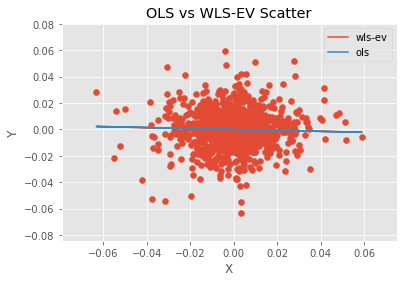

WLS-EV Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [-0.00094035 -0.11885111]
robust bse standard errors: [ 0.00148792  0.04604672]
t-stats: [-0.63198733 -2.58109818]
In sample R_squared: 0.00406467
In sample R_squared of standardized regression: 0.00212433
Out of sample R_squared: 0.00480561
-------------------------------------------------------------------------------------------------------


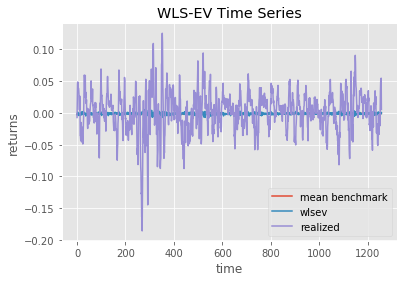

OLS Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [-0.0006683  -0.15722703]
robust bse standard errors: [ 0.00125121  0.05024195]
t-stats: [-0.53412608 -3.12939743]
In sample R_squared: 0.00438418
Out of sample R_squared: 0.00331397
-------------------------------------------------------------------------------------------------------


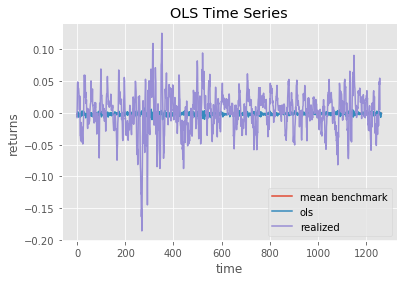

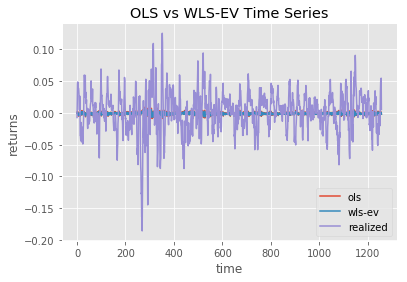

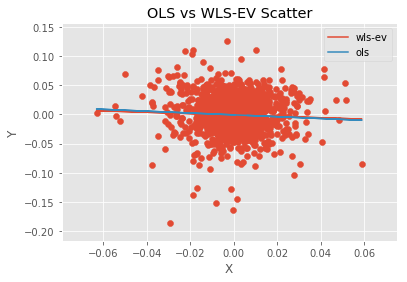

WLS-EV Estimation Results
Forecast Horizon: 14
-------------------------------------------------------------------------------------------------------
betas: [-0.0020189  -0.07242053]
robust bse standard errors: [ 0.00319475  0.06564762]
t-stats: [-0.63194288 -1.10317072]
In sample R_squared: 0.001249
In sample R_squared of standardized regression: 0.00052328
Out of sample R_squared: 0.00353514
-------------------------------------------------------------------------------------------------------


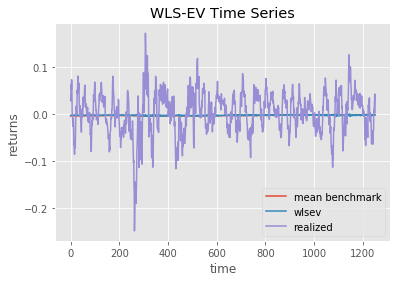

OLS Estimation Results
Forecast Horizon: 14
-------------------------------------------------------------------------------------------------------
betas: [-0.00141016 -0.13954419]
robust bse standard errors: [ 0.00193147  0.06683011]
t-stats: [-0.73009865 -2.08804381]
In sample R_squared: 0.00182433
Out of sample R_squared: 0.00223691
-------------------------------------------------------------------------------------------------------


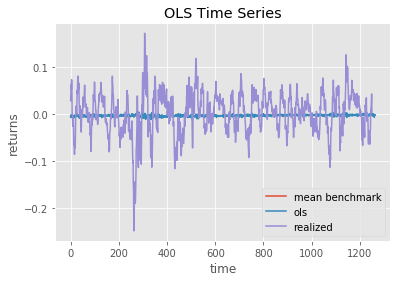

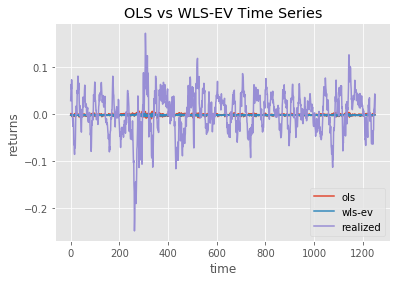

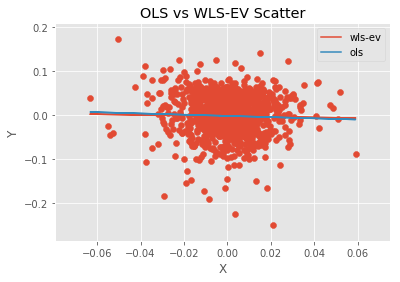

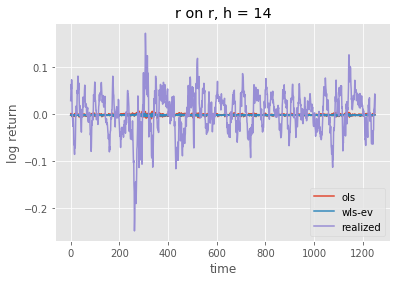

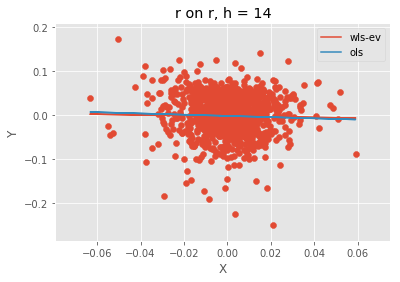

WLS-EV Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.00318385 -0.05335016]
robust bse standard errors: [ 0.0053015   0.08417147]
t-stats: [-0.60055688 -0.63382711]
In sample R_squared: 0.00059963
In sample R_squared of standardized regression: 0.00028248
Out of sample R_squared: 0.00472952
-------------------------------------------------------------------------------------------------------


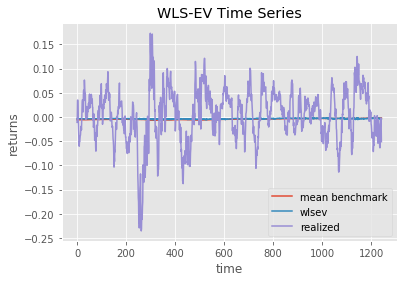

OLS Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.00221915 -0.1576041 ]
robust bse standard errors: [ 0.00249936  0.07328227]
t-stats: [-0.88788716 -2.15064415]
In sample R_squared: 0.00150724
Out of sample R_squared: 0.00045995
-------------------------------------------------------------------------------------------------------


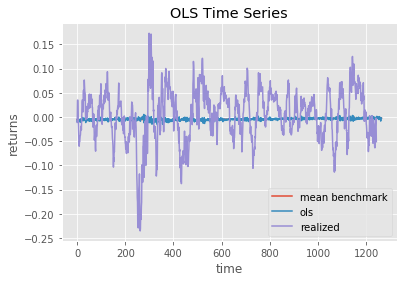

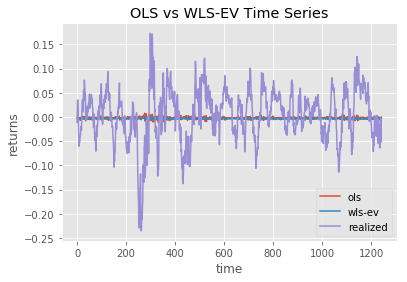

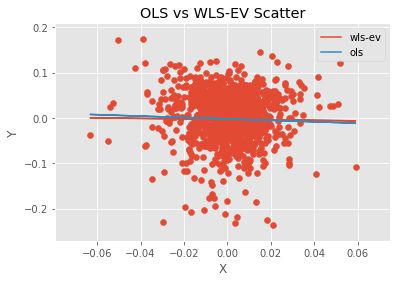

WLS-EV Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.00585398 -0.09940254]
robust bse standard errors: [ 0.01128582  0.12111459]
t-stats: [-0.51870265 -0.82073137]
In sample R_squared: 0.00037255
In sample R_squared of standardized regression: 0.00035203
Out of sample R_squared: 0.01379745
-------------------------------------------------------------------------------------------------------


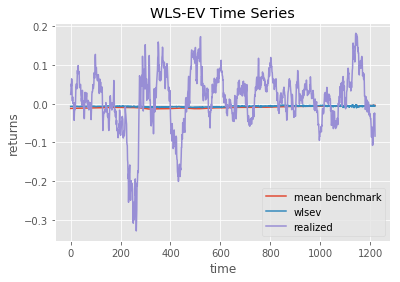

OLS Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.00428698 -0.16511662]
robust bse standard errors: [ 0.00366447  0.09957551]
t-stats: [-1.16987844 -1.65820509]
In sample R_squared: 0.00082557
Out of sample R_squared: 0.00073072
-------------------------------------------------------------------------------------------------------


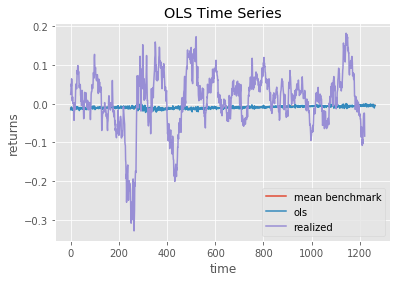

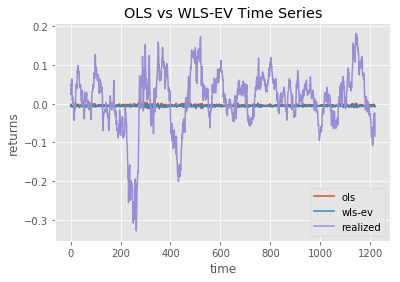

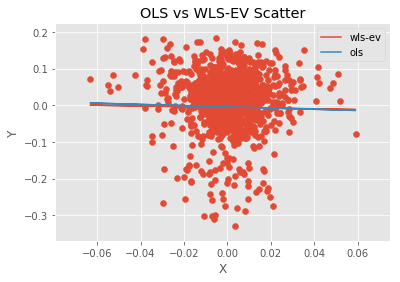

WLS-EV Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.0084222  -0.01150266]
robust bse standard errors: [ 0.01777658  0.15074672]
t-stats: [-0.47378043 -0.07630454]
In sample R_squared: -0.00051473
In sample R_squared of standardized regression: 0.00014386
Out of sample R_squared: 0.01948862
-------------------------------------------------------------------------------------------------------


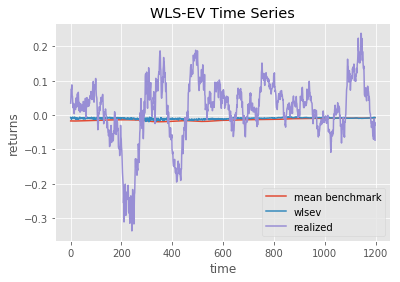

OLS Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.00589433 -0.12745945]
robust bse standard errors: [ 0.00449655  0.11746103]
t-stats: [-1.31085632 -1.08512116]
In sample R_squared: 0.00033684
Out of sample R_squared: 0.00011799
-------------------------------------------------------------------------------------------------------


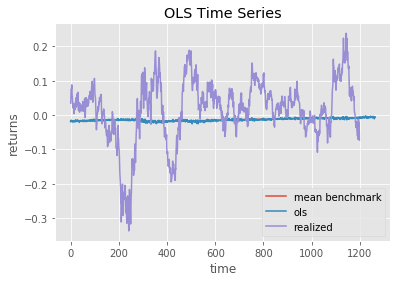

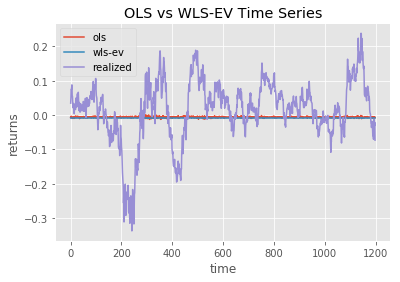

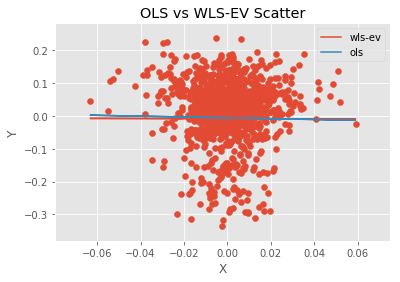

WLS-EV Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.01092985  0.07382317]
robust bse standard errors: [ 0.02409724  0.17035959]
t-stats: [-0.45357264  0.43333734]
In sample R_squared: -0.00082921
In sample R_squared of standardized regression: 0.00023496
Out of sample R_squared: 0.02296239
-------------------------------------------------------------------------------------------------------


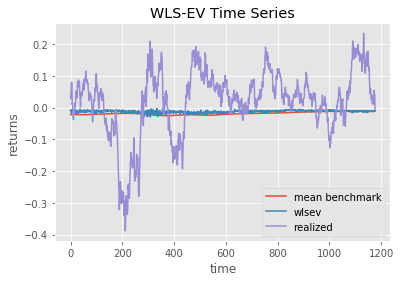

OLS Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.0078039  -0.05017709]
robust bse standard errors: [ 0.00532518  0.13228464]
t-stats: [-1.46547235 -0.37931158]
In sample R_squared: 3.798e-05
Out of sample R_squared: 9.856e-05
-------------------------------------------------------------------------------------------------------


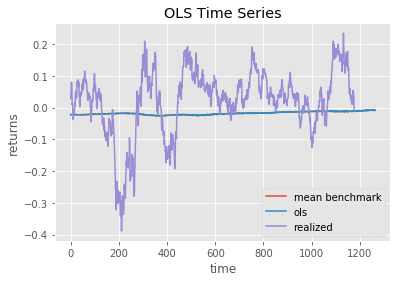

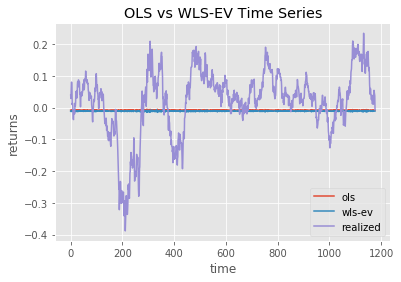

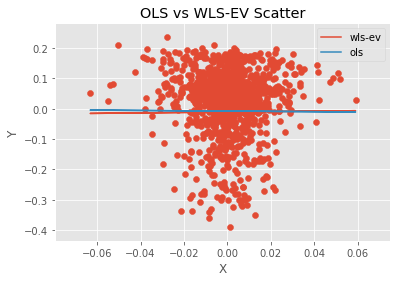

In [37]:
# 2. least squares estimates weighted by ex-ante return variance (WLS-EV) using Johnson (2016)
# ------------------------------------------------------------------------------------------------------------

for i in (1, 7, 14, 22,44, 66, 88):
    # set forecast_horizon
    forecast_horizon = i

    # WLS-EV
    wlsev_obj = Wlsev_model(data_retvol_var['logreturns'][:-1].as_matrix(), data_retvol_var['logreturns'][1:].as_matrix(), data_retvol_var['var_logret_daily_est'][:-1].as_matrix(), forecast_horizon)
    wlsev_obj.fit()
    # OOS evaluation to get Rsquared
    wlsev_obj.evaluate()
    wlsev_obj.print_results()
    wlsev_obj.plot_results()
    # get data
    X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

    # OLS
    ols_obj = OLS_model(data_retvol_var['logreturns'][:-1].as_matrix(), data_retvol_var['logreturns'][1:].as_matrix(), forecast_horizon)
    ols_obj.fit()
    # OOS evaluation to get Rsquared
    ols_obj.evaluate()
    ols_obj.print_results()
    ols_obj.plot_results()
    # get data
    X, Y, y_ols = ols_obj.get_plot_data_ols()


    # Visualisation
    # ------------------------------------------------------------------------------------------------------------

    # time series plot
    plot_results(X,Y,y_wlsev, y_ols)
    # scatter plot
    plot_scatter(X,Y,y_wlsev, y_ols)

    if forecast_horizon == 14:
        # time series plot
        plt = plot_results_custom(X,Y,y_wlsev, y_ols, 'r on r, h = 14', 'log return')
        # scatter plot
        plt = plot_scatter_custom(X,Y,y_wlsev, y_ols, 'r on r, h = 14')

### Returns on VRP

WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ -9.88500000e-05  -2.04506000e-03]
robust bse standard errors: [ 0.00020455  0.00941284]
t-stats: [-0.48325805 -0.21726331]
In sample R_squared: 0.00017832
In sample R_squared of standardized regression: 7.327e-05
Out of sample R_squared: -0.00193011
-------------------------------------------------------------------------------------------------------


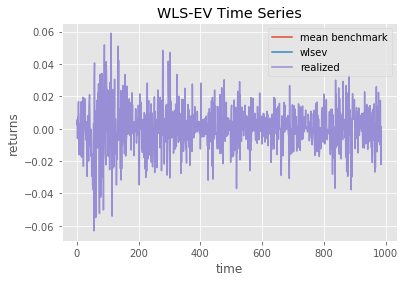

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.0003453  -0.00894136]
robust bse standard errors: [ 0.00029206  0.01124956]
t-stats: [-1.18230377 -0.79481913]
In sample R_squared: 0.00051238
Out of sample R_squared: 0.00205945
-------------------------------------------------------------------------------------------------------


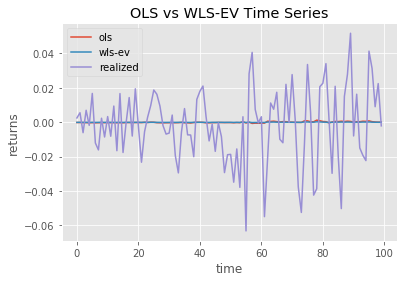

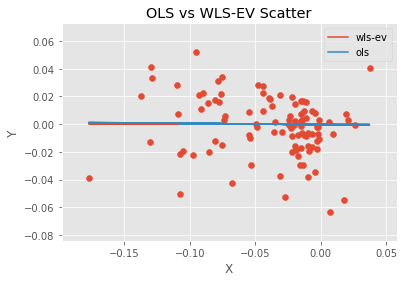

WLS-EV Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.00113106  0.03911689]
robust bse standard errors: [ 0.00429466  0.17471156]
t-stats: [-0.26336466  0.22389413]
In sample R_squared: -0.003353
In sample R_squared of standardized regression: 5.291e-05
Out of sample R_squared: -0.00498778
-------------------------------------------------------------------------------------------------------


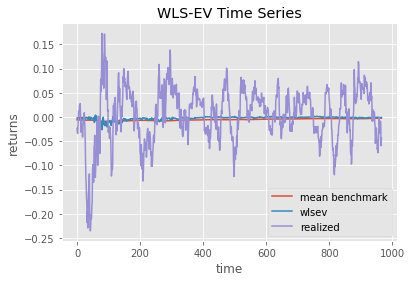

OLS Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.00485632 -0.09366526]
robust bse standard errors: [ 0.00300483  0.08546416]
t-stats: [-1.61616896 -1.09595942]
In sample R_squared: 0.00323847
Out of sample R_squared: 0.00018305
-------------------------------------------------------------------------------------------------------


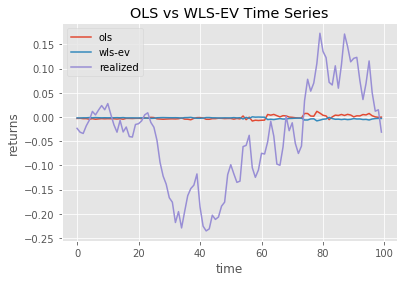

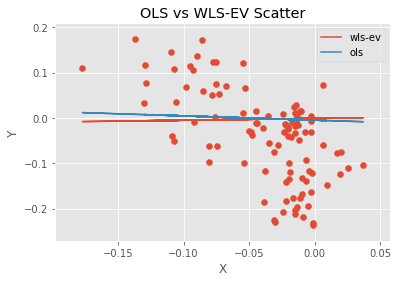

WLS-EV Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.00179079  0.19346506]
robust bse standard errors: [ 0.00847331  0.34851251]
t-stats: [-0.21134434  0.55511656]
In sample R_squared: -0.01379294
In sample R_squared of standardized regression: 0.00013946
Out of sample R_squared: -0.0152292
-------------------------------------------------------------------------------------------------------


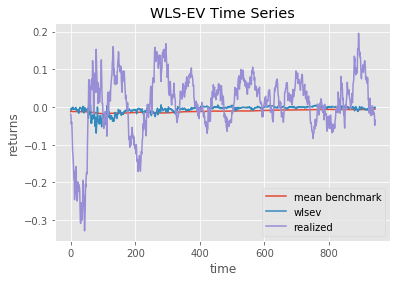

OLS Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.00731993 -0.09964934]
robust bse standard errors: [ 0.00456235  0.10815032]
t-stats: [-1.60442089 -0.92139659]
In sample R_squared: 0.00177381
Out of sample R_squared: -0.00475457
-------------------------------------------------------------------------------------------------------


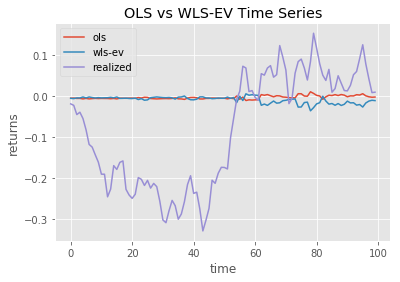

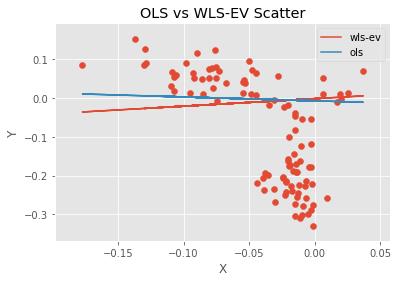

WLS-EV Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.00156743  0.25151454]
robust bse standard errors: [ 0.01258467  0.51818512]
t-stats: [-0.12455055  0.48537584]
In sample R_squared: -0.01766015
In sample R_squared of standardized regression: 8.832e-05
Out of sample R_squared: 0.01016979
-------------------------------------------------------------------------------------------------------


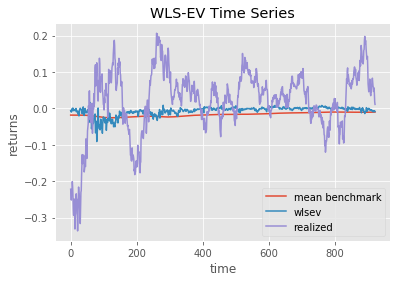

OLS Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.01165855 -0.16705564]
robust bse standard errors: [ 0.00600124  0.14085   ]
t-stats: [-1.94269144 -1.18605356]
In sample R_squared: 0.00334577
Out of sample R_squared: -0.01520552
-------------------------------------------------------------------------------------------------------


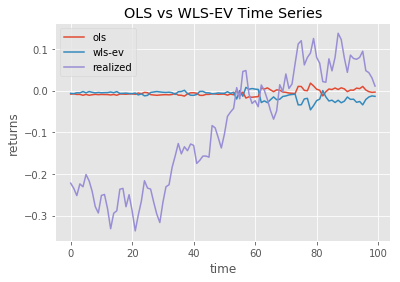

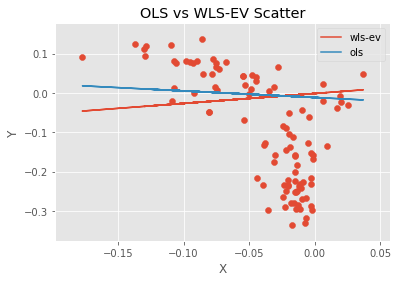

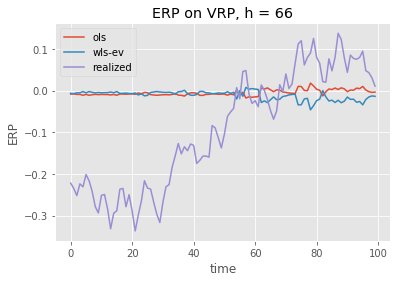

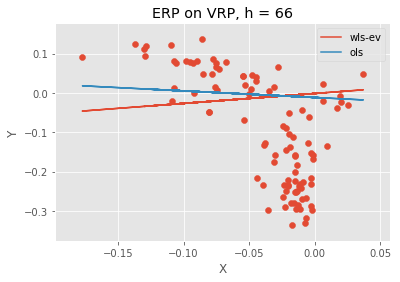

WLS-EV Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.00046621  0.17471998]
robust bse standard errors: [ 0.01669545  0.67408621]
t-stats: [-0.02792434  0.25919531]
In sample R_squared: -0.01433513
In sample R_squared of standardized regression: 2.01e-05
Out of sample R_squared: 0.08472846
-------------------------------------------------------------------------------------------------------


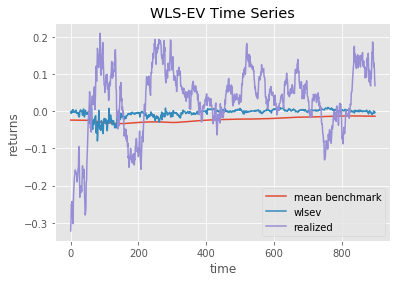

OLS Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.01834069 -0.33668341]
robust bse standard errors: [ 0.00726865  0.12755497]
t-stats: [-2.52325934 -2.63951618]
In sample R_squared: 0.00966801
Out of sample R_squared: -0.04124573
-------------------------------------------------------------------------------------------------------


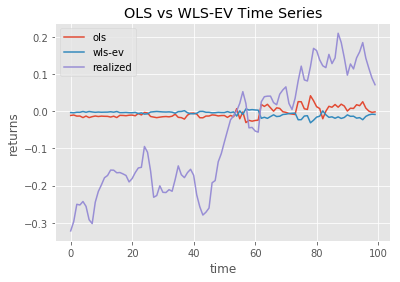

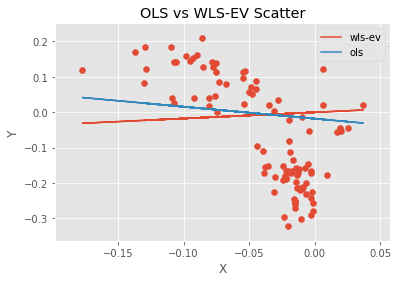

In [21]:
# set forecast_horizon
for i in (1,22,44, 66, 88):
    forecast_horizon = i

    # WLS-EV
    wlsev_obj = Wlsev_model(data_vrperp_var['vrp'][:-1].as_matrix(), data_vrperp_var['logreturns'][1:].as_matrix(), data_vrperp_var['var_logret_daily_est'][:-1].as_matrix(), forecast_horizon)
    wlsev_obj.fit()
    # OOS evaluation to get Rsquared
    wlsev_obj.evaluate()
    wlsev_obj.print_results()
    wlsev_obj.plot_results()
    # get data
    X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

    # OLS
    ols_obj = OLS_model(data_vrperp_var['vrp'][:-1].as_matrix(), data_vrperp_var['logreturns'][1:].as_matrix(), forecast_horizon)
    ols_obj.fit()
    # OOS evaluation to get Rsquared
    ols_obj.evaluate()
    ols_obj.print_results()
    # get data
    X, Y, y_ols = ols_obj.get_plot_data_ols()


    # Visualisation
    # ------------------------------------------------------------------------------------------------------------

    # time series plot
    plot_results(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
    # scatter plot
    plot_scatter(X[:100],Y[:100],y_wlsev[:100], y_ols[:100])
    
    if forecast_horizon == 66:
        # time series plot
        plt = plot_results_custom(X[:100],Y[:100],y_wlsev[:100], y_ols[:100], 'ERP on VRP, h = 66', 'ERP')
        # scatter plot
        plt = plot_scatter_custom(X[:100],Y[:100],y_wlsev[:100], y_ols[:100], 'ERP on VRP, h = 66')

### Regress ERP on VRP

##### forecast horizon several months ahead months

WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.00015919 -0.0021461 ]
robust bse standard errors: [ 0.00020436  0.00942014]
t-stats: [-0.77896497 -0.22782012]
In sample R_squared: 0.00018072
In sample R_squared of standardized regression: 0.00018752
Out of sample R_squared: -0.00173037
-------------------------------------------------------------------------------------------------------


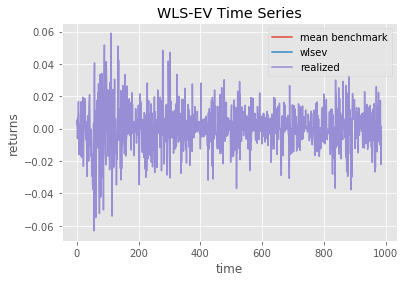

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [-0.00040223 -0.00877899]
robust bse standard errors: [ 0.00029228  0.01125565]
t-stats: [-1.37620439 -0.77996319]
In sample R_squared: 0.00049378
Out of sample R_squared: 0.00197697
-------------------------------------------------------------------------------------------------------


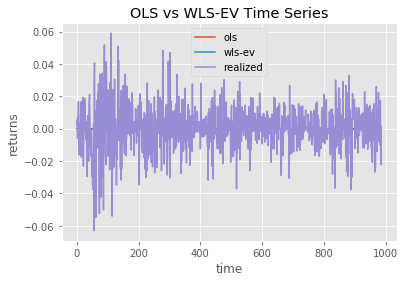

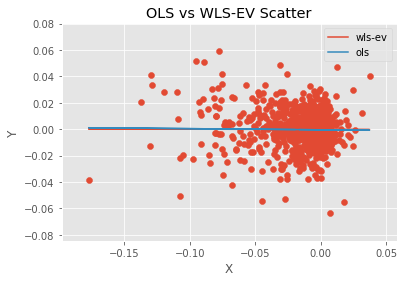

WLS-EV Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.00246337  0.0359187 ]
robust bse standard errors: [ 0.00429123  0.17479   ]
t-stats: [-0.57404743  0.20549631]
In sample R_squared: -0.00296745
In sample R_squared of standardized regression: 0.00014708
Out of sample R_squared: -0.00124251
-------------------------------------------------------------------------------------------------------


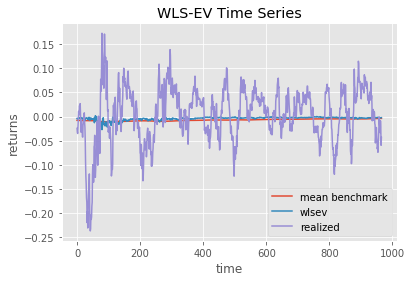

OLS Estimation Results
Forecast Horizon: 22
-------------------------------------------------------------------------------------------------------
betas: [-0.0061282  -0.09095826]
robust bse standard errors: [ 0.00302023  0.08562762]
t-stats: [-2.02904749 -1.06225368]
In sample R_squared: 0.00302612
Out of sample R_squared: -0.00097712
-------------------------------------------------------------------------------------------------------


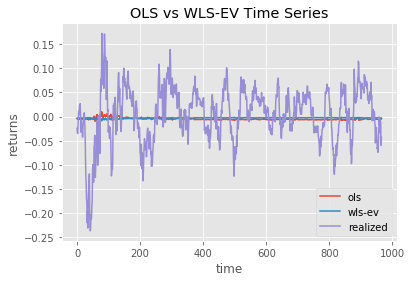

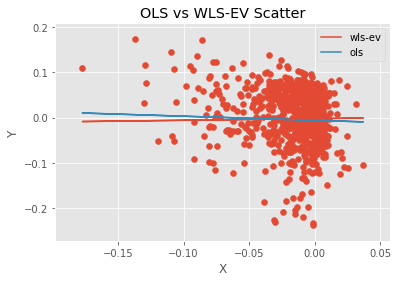

WLS-EV Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.00443871  0.18814161]
robust bse standard errors: [ 0.0084667   0.34868072]
t-stats: [-0.52425465  0.53958135]
In sample R_squared: -0.01270943
In sample R_squared of standardized regression: 0.00023822
Out of sample R_squared: -0.0087472
-------------------------------------------------------------------------------------------------------


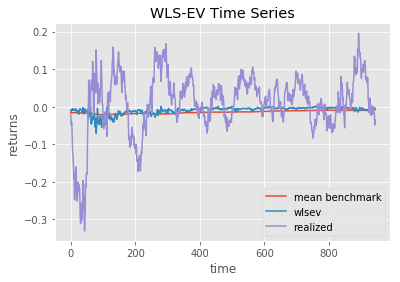

OLS Estimation Results
Forecast Horizon: 44
-------------------------------------------------------------------------------------------------------
betas: [-0.00989859 -0.09577735]
robust bse standard errors: [ 0.00460588  0.10847897]
t-stats: [-2.14911879 -0.88291168]
In sample R_squared: 0.0016099
Out of sample R_squared: -0.00611007
-------------------------------------------------------------------------------------------------------


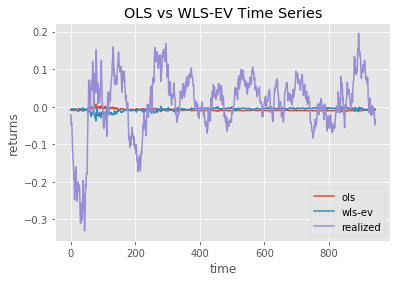

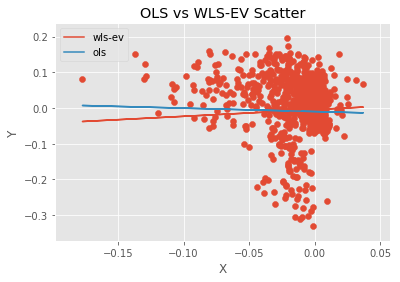

WLS-EV Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.00549334  0.24466248]
robust bse standard errors: [ 0.0125741   0.51845482]
t-stats: [-0.43687771  0.47190704]
In sample R_squared: -0.01634176
In sample R_squared of standardized regression: 0.00016389
Out of sample R_squared: 0.02151385
-------------------------------------------------------------------------------------------------------


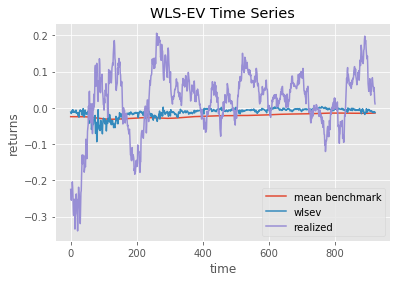

OLS Estimation Results
Forecast Horizon: 66
-------------------------------------------------------------------------------------------------------
betas: [-0.01557765 -0.16349981]
robust bse standard errors: [ 0.00607814  0.1414175 ]
t-stats: [-2.56289831 -1.1561498 ]
In sample R_squared: 0.00312136
Out of sample R_squared: -0.01771482
-------------------------------------------------------------------------------------------------------


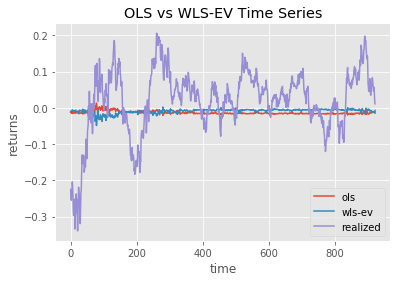

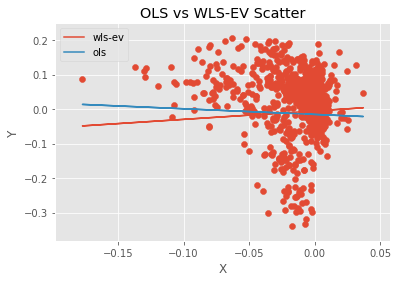

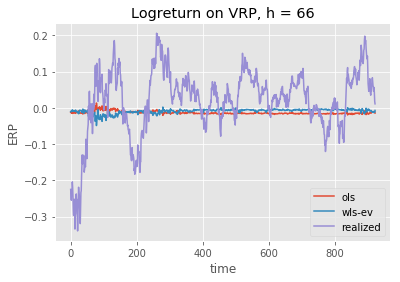

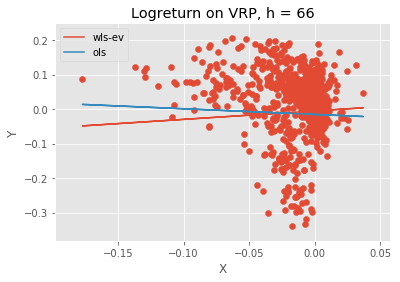

WLS-EV Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.00567134  0.16602583]
robust bse standard errors: [ 0.0166813   0.67433491]
t-stats: [-0.33998171  0.24620679]
In sample R_squared: -0.01329637
In sample R_squared of standardized regression: 6.536e-05
Out of sample R_squared: 0.10099734
-------------------------------------------------------------------------------------------------------


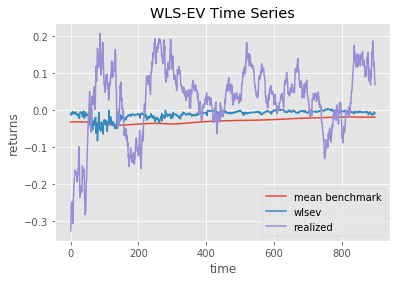

OLS Estimation Results
Forecast Horizon: 88
-------------------------------------------------------------------------------------------------------
betas: [-0.02362547 -0.33455495]
robust bse standard errors: [ 0.00738363  0.12916208]
t-stats: [-3.1997081  -2.59019476]
In sample R_squared: 0.0092441
Out of sample R_squared: -0.04586191
-------------------------------------------------------------------------------------------------------


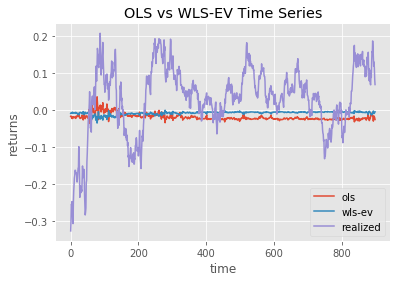

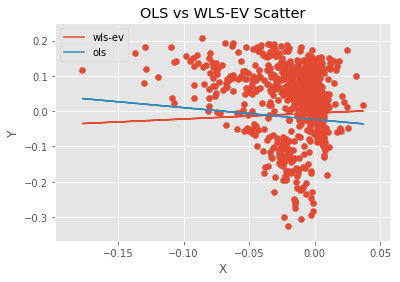

In [22]:
# set forecast_horizon
for i in (1,22,44, 66, 88):
    forecast_horizon = i

    # WLS-EV
    wlsev_obj = Wlsev_model(data_vrperp_var['vrp'][:-1].as_matrix(), data_vrperp_var['erp'][1:].as_matrix(), data_vrperp_var['var_logret_daily_est'][:-1].as_matrix(), forecast_horizon)
    wlsev_obj.fit()
    # OOS evaluation to get Rsquared
    wlsev_obj.evaluate()
    wlsev_obj.print_results()
    wlsev_obj.plot_results()
    # get data
    X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

    # OLS
    ols_obj = OLS_model(data_vrperp_var['vrp'][:-1].as_matrix(), data_vrperp_var['erp'][1:].as_matrix(), forecast_horizon)
    ols_obj.fit()
    # OOS evaluation to get Rsquared
    ols_obj.evaluate()
    ols_obj.print_results()
    # get data
    X, Y, y_ols = ols_obj.get_plot_data_ols()


    # Visualisation
    # ------------------------------------------------------------------------------------------------------------

    # time series plot
    plot_results(X,Y,y_wlsev, y_ols)
    # scatter plot
    plot_scatter(X,Y,y_wlsev, y_ols)
    
    if forecast_horizon == 66:
        # time series plot
        plt = plot_results_custom(X,Y,y_wlsev, y_ols, 'Logreturn on VRP, h = 66', 'ERP')
        # scatter plot
        plt = plot_scatter_custom(X,Y,y_wlsev, y_ols, 'Logreturn on VRP, h = 66')

### Regress P-Moments on Q-Moments


### P_skewness_1 = f(Q_skewness_7) + error

P_skewness_1 = f(Q_skewness_7) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ 0.  0.]
robust bse standard errors: [ 0.  0.]
t-stats: [ 0.98705005  1.88704837]
In sample R_squared: -0.00053159
In sample R_squared of standardized regression: 0.00041055
Out of sample R_squared: 0.00212885
-------------------------------------------------------------------------------------------------------


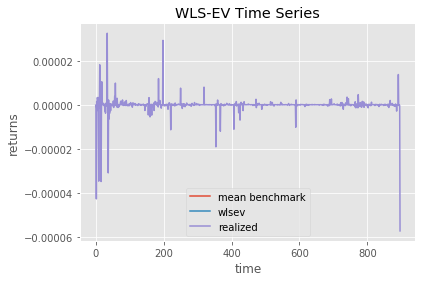

OLS Estimation Results
Forecast Horizon: 1
-------------------------------------------------------------------------------------------------------
betas: [ -2.90000000e-07   2.00000000e-08]
robust bse standard errors: [  4.50000000e-07   1.60000000e-07]
t-stats: [-0.63250272  0.11969562]
In sample R_squared: 1.64e-06
Out of sample R_squared: -0.00064836
-------------------------------------------------------------------------------------------------------


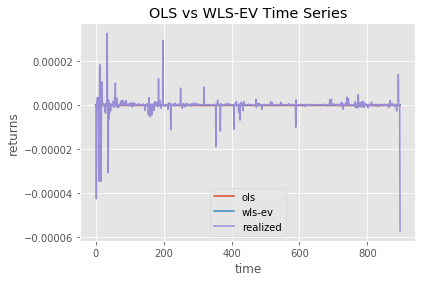

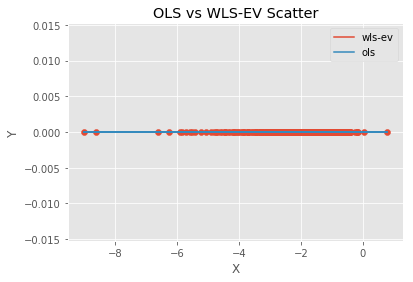

In [23]:
forecast_horizon = 1

# P_skewness_7 = f(Q_skewness_7) + error
print('P_skewness_1 = f(Q_skewness_7) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_skewness_7 = f(Q_skewness_7) + error

P_skewness_7 = f(Q_skewness_7) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [  0.00000000e+00   1.00000000e-08]
robust bse standard errors: [  1.00000000e-08   1.00000000e-08]
t-stats: [ 0.21839153  1.92513317]
In sample R_squared: -0.00419675
In sample R_squared of standardized regression: 0.00037063
Out of sample R_squared: 0.08027346
-------------------------------------------------------------------------------------------------------


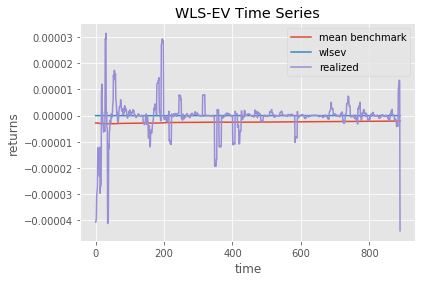

OLS Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [ -3.36000000e-06  -9.10000000e-07]
robust bse standard errors: [  2.89000000e-06   1.11000000e-06]
t-stats: [-1.16289528 -0.8197447 ]
In sample R_squared: 0.0006436
Out of sample R_squared: 0.00988175
-------------------------------------------------------------------------------------------------------


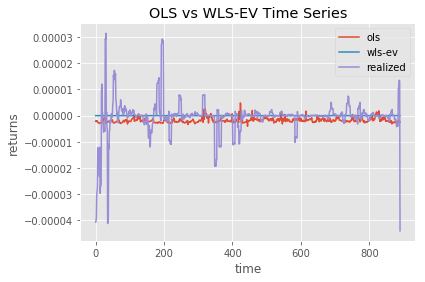

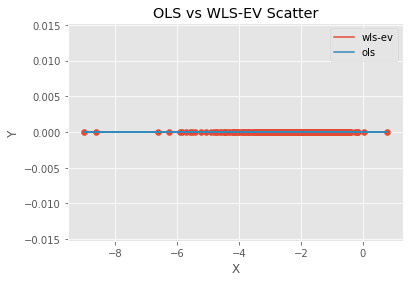

In [24]:
forecast_horizon = 7

# P_skewness_7 = f(Q_skewness_7) + error
print('P_skewness_7 = f(Q_skewness_7) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_kurtosis_7 = f(Q_kurtosis_7) + error

P_kurtosis_7 = f(Q_kurtosis_7) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [ 0. -0.]
robust bse standard errors: [ 0. -0.]
t-stats: [  3.00756834  15.50860964]
In sample R_squared: -0.01625856
In sample R_squared of standardized regression: -0.34742083
Out of sample R_squared: 0.61131906
-------------------------------------------------------------------------------------------------------


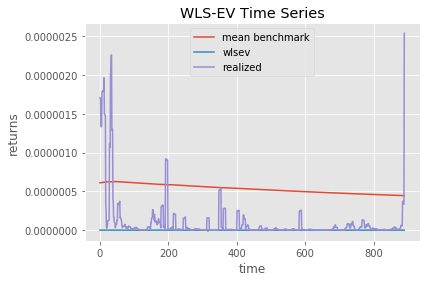

OLS Estimation Results
Forecast Horizon: 7
-------------------------------------------------------------------------------------------------------
betas: [ -3.36000000e-06  -9.10000000e-07]
robust bse standard errors: [  2.89000000e-06   1.11000000e-06]
t-stats: [-1.16289528 -0.8197447 ]
In sample R_squared: 0.0006436
Out of sample R_squared: 0.00988175
-------------------------------------------------------------------------------------------------------


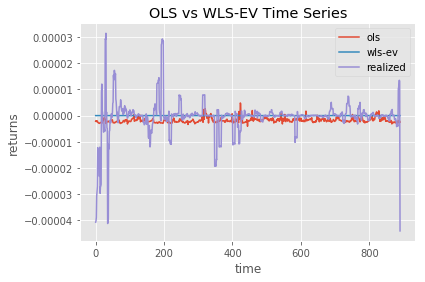

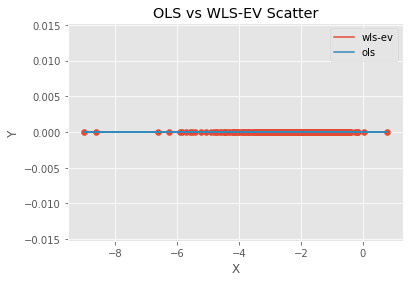

In [25]:
forecast_horizon = 7

# P_kurtosis_7 = f(Q_kurtosis_7) + error
print('P_kurtosis_7 = f(Q_kurtosis_7) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_7'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_7'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_skewness_30 = f(Q_skewness_30) + error

P_skewness_30 = f(Q_skewness_30) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 30
-------------------------------------------------------------------------------------------------------
betas: [  3.00000000e-08   5.00000000e-08]
robust bse standard errors: [  7.00000000e-08   4.00000000e-08]
t-stats: [ 0.34994502  1.447617  ]
In sample R_squared: -0.01349042
In sample R_squared of standardized regression: 0.00029035
Out of sample R_squared: 0.40100127
-------------------------------------------------------------------------------------------------------


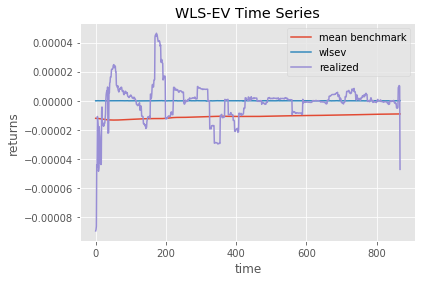

OLS Estimation Results
Forecast Horizon: 30
-------------------------------------------------------------------------------------------------------
betas: [ -2.14500000e-05  -7.51000000e-06]
robust bse standard errors: [  1.25500000e-05   5.34000000e-06]
t-stats: [-1.70974077 -1.40497648]
In sample R_squared: 0.00438192
Out of sample R_squared: 0.05519165
-------------------------------------------------------------------------------------------------------


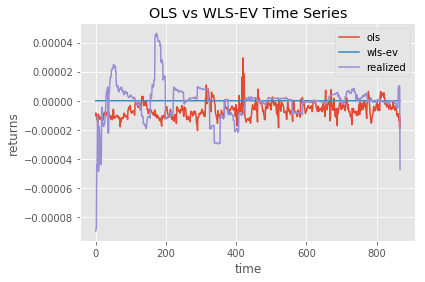

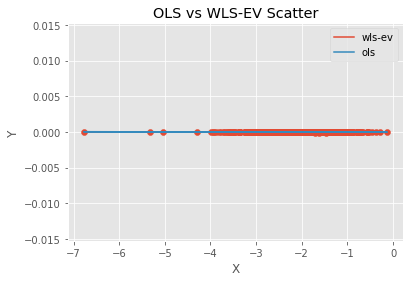

In [26]:
forecast_horizon = 30

# P_skewness_30 = f(Q_skewness_30) + error
print('P_skewness_30 = f(Q_skewness_30) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_30'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_30'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_kurtosis_30 = f(Q_kurtosis_30) + error

P_kurtosis_30 = f(Q_kurtosis_30) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 30
-------------------------------------------------------------------------------------------------------
betas: [  1.00000000e-08  -0.00000000e+00]
robust bse standard errors: [ 0. -0.]
t-stats: [ 2.04134283  3.55435469]
In sample R_squared: -0.04006766
In sample R_squared of standardized regression: -0.34952836
Out of sample R_squared: 0.83917198
-------------------------------------------------------------------------------------------------------


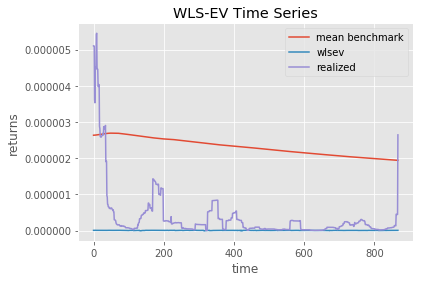

OLS Estimation Results
Forecast Horizon: 30
-------------------------------------------------------------------------------------------------------
betas: [ -2.14500000e-05  -7.51000000e-06]
robust bse standard errors: [  1.25500000e-05   5.34000000e-06]
t-stats: [-1.70974077 -1.40497648]
In sample R_squared: 0.00438192
Out of sample R_squared: 0.05519165
-------------------------------------------------------------------------------------------------------


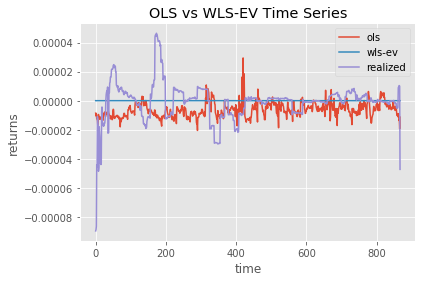

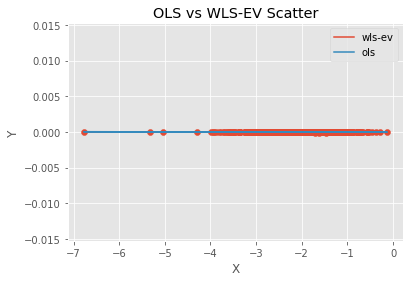

In [27]:
forecast_horizon = 30

# P_kurtosis_30 = f(Q_kurtosis_30) + error
print('P_kurtosis_30 = f(Q_kurtosis_30) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_30'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_30'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_skewness_60 = f(Q_skewness_60) + error

P_skewness_60 = f(Q_skewness_60) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 60
-------------------------------------------------------------------------------------------------------
betas: [  2.20000000e-07   1.80000000e-07]
robust bse standard errors: [  2.30000000e-07   1.20000000e-07]
t-stats: [ 0.95613484  1.53086422]
In sample R_squared: -0.03014239
In sample R_squared of standardized regression: 0.00025912
Out of sample R_squared: 0.68903147
-------------------------------------------------------------------------------------------------------


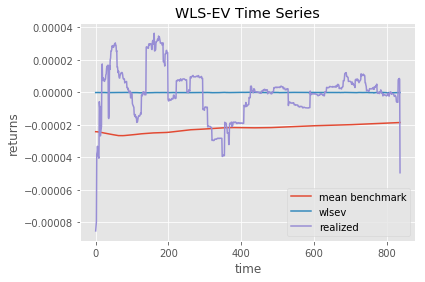

OLS Estimation Results
Forecast Horizon: 60
-------------------------------------------------------------------------------------------------------
betas: [ -7.14700000e-05  -2.97300000e-05]
robust bse standard errors: [  2.75500000e-05   1.26300000e-05]
t-stats: [-2.59450138 -2.35438372]
In sample R_squared: 0.02342112
Out of sample R_squared: 0.19293279
-------------------------------------------------------------------------------------------------------


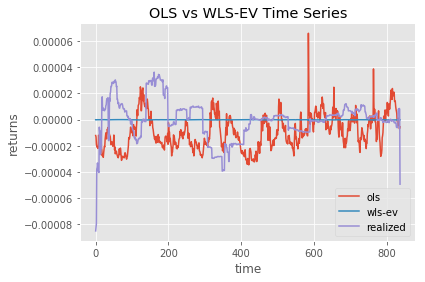

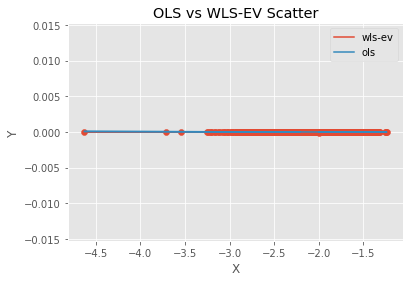

In [28]:
forecast_horizon = 60

# P_skewness_60 = f(Q_skewness_60) + error
print('P_skewness_60 = f(Q_skewness_60) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_60'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_60'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_kurtosis_60 = f(Q_kurtosis_60) + error

P_kurtosis_60 = f(Q_kurtosis_60) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 60
-------------------------------------------------------------------------------------------------------
betas: [  2.00000000e-08  -0.00000000e+00]
robust bse standard errors: [  2.00000000e-08  -0.00000000e+00]
t-stats: [ 1.38368366  2.01642755]
In sample R_squared: -0.06302754
In sample R_squared of standardized regression: -0.3476566
Out of sample R_squared: 0.92299761
-------------------------------------------------------------------------------------------------------


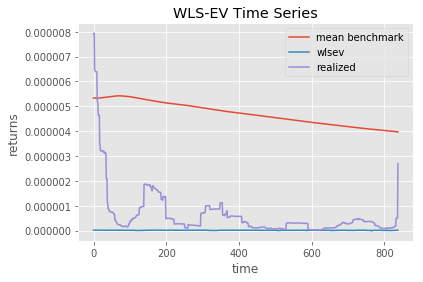

OLS Estimation Results
Forecast Horizon: 60
-------------------------------------------------------------------------------------------------------
betas: [ -7.14700000e-05  -2.97300000e-05]
robust bse standard errors: [  2.75500000e-05   1.26300000e-05]
t-stats: [-2.59450138 -2.35438372]
In sample R_squared: 0.02342112
Out of sample R_squared: 0.19293279
-------------------------------------------------------------------------------------------------------


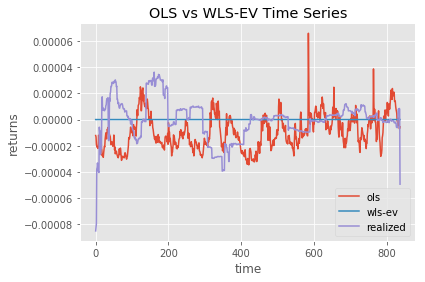

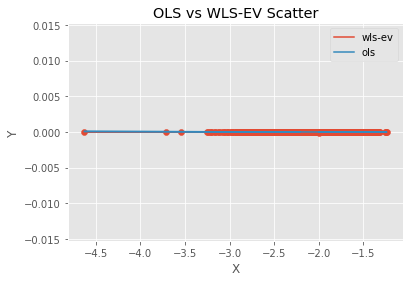

In [29]:
forecast_horizon = 60

# P_kurtosis_60 = f(Q_kurtosis_60) + error
print('P_kurtosis_60 = f(Q_kurtosis_60) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_60'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_60'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_skewness_91 = f(Q_skewness_91) + error

P_skewness_91 = f(Q_skewness_91) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 91
-------------------------------------------------------------------------------------------------------
betas: [  2.00000000e-07   2.30000000e-07]
robust bse standard errors: [  3.40000000e-07   1.90000000e-07]
t-stats: [ 0.60814324  1.19822299]
In sample R_squared: -0.04736882
In sample R_squared of standardized regression: 0.00027776
Out of sample R_squared: 0.78591957
-------------------------------------------------------------------------------------------------------


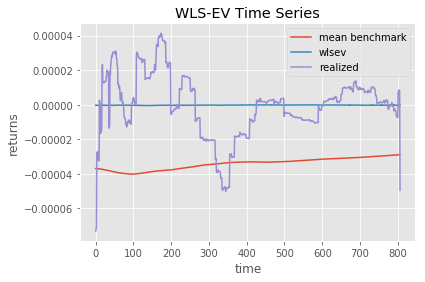

OLS Estimation Results
Forecast Horizon: 91
-------------------------------------------------------------------------------------------------------
betas: [ -8.77500000e-05  -3.55500000e-05]
robust bse standard errors: [  2.85800000e-05   1.33900000e-05]
t-stats: [-3.06972839 -2.65520127]
In sample R_squared: 0.02378636
Out of sample R_squared: 0.44141169
-------------------------------------------------------------------------------------------------------


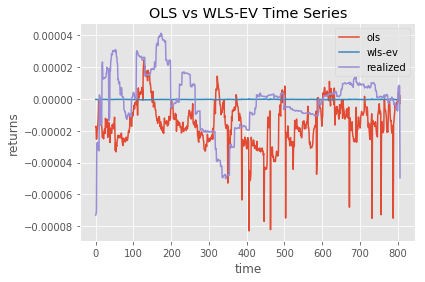

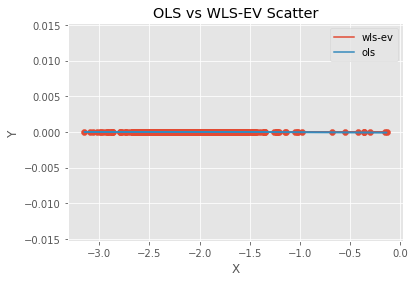

In [30]:
forecast_horizon = 91

# P_skewness_91 = f(Q_skewness_91) + error
print('P_skewness_91 = f(Q_skewness_91) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_91'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_91'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_kurtosis_91 = f(Q_kurtosis_91) + error

P_kurtosis_91 = f(Q_kurtosis_91) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 91
-------------------------------------------------------------------------------------------------------
betas: [  3.00000000e-08  -0.00000000e+00]
robust bse standard errors: [  3.00000000e-08  -0.00000000e+00]
t-stats: [ 1.21789759  1.44671541]
In sample R_squared: -0.08707721
In sample R_squared of standardized regression: -0.34752966
Out of sample R_squared: 0.95656838
-------------------------------------------------------------------------------------------------------


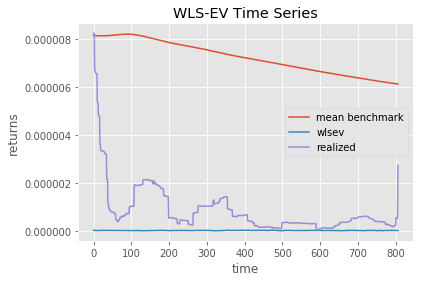

OLS Estimation Results
Forecast Horizon: 91
-------------------------------------------------------------------------------------------------------
betas: [ -8.77500000e-05  -3.55500000e-05]
robust bse standard errors: [  2.85800000e-05   1.33900000e-05]
t-stats: [-3.06972839 -2.65520127]
In sample R_squared: 0.02378636
Out of sample R_squared: 0.44141169
-------------------------------------------------------------------------------------------------------


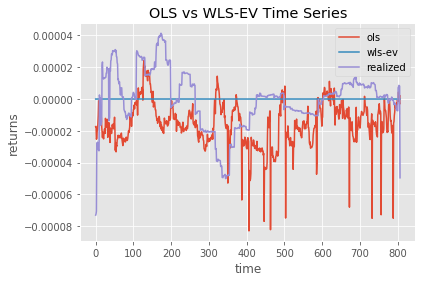

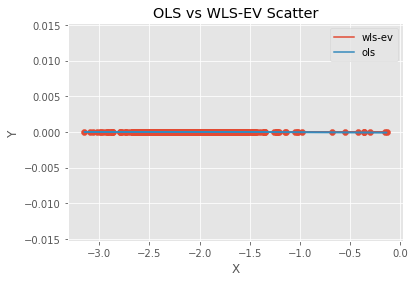

In [31]:
forecast_horizon = 91

# P_kurtosis_91 = f(Q_kurtosis_91) + error
print('P_kurtosis_91 = f(Q_kurtosis_91) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_91'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_91'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_skewness_182 = f(Q_skewness_182) + error

P_skewness_182 = f(Q_skewness_182) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 182
-------------------------------------------------------------------------------------------------------
betas: [ -1.03000000e-06  -2.70000000e-07]
robust bse standard errors: [  1.90000000e-06   8.60000000e-07]
t-stats: [-0.54415333 -0.3086597 ]
In sample R_squared: -0.11416682
In sample R_squared of standardized regression: 0.00014094
Out of sample R_squared: 0.88902533
-------------------------------------------------------------------------------------------------------


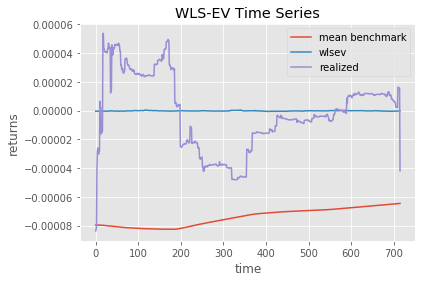

OLS Estimation Results
Forecast Horizon: 182
-------------------------------------------------------------------------------------------------------
betas: [ -1.85470000e-04  -6.47600000e-05]
robust bse standard errors: [  4.98600000e-05   2.17900000e-05]
t-stats: [-3.71993281 -2.97227516]
In sample R_squared: 0.02560176
Out of sample R_squared: 0.37100323
-------------------------------------------------------------------------------------------------------


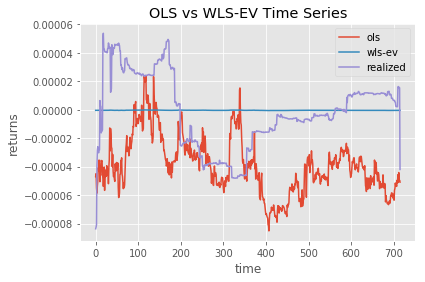

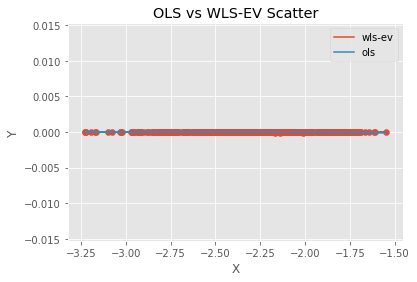

In [32]:
forecast_horizon = 182

# P_skewness_182 = f(Q_skewness_182) + error
print('P_skewness_182 = f(Q_skewness_182) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_182'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_182'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_kurtosis_182 = f(Q_kurtosis_182) + error

P_kurtosis_182 = f(Q_kurtosis_182) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 182
-------------------------------------------------------------------------------------------------------
betas: [  1.10000000e-07  -1.00000000e-08]
robust bse standard errors: [  9.00000000e-08  -0.00000000e+00]
t-stats: [ 1.12854407  1.66872102]
In sample R_squared: -0.15882366
In sample R_squared of standardized regression: -0.3311212
Out of sample R_squared: 0.97629185
-------------------------------------------------------------------------------------------------------


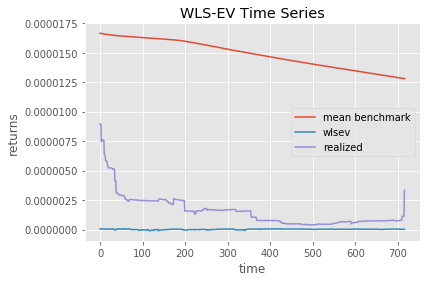

OLS Estimation Results
Forecast Horizon: 182
-------------------------------------------------------------------------------------------------------
betas: [ -1.85470000e-04  -6.47600000e-05]
robust bse standard errors: [  4.98600000e-05   2.17900000e-05]
t-stats: [-3.71993281 -2.97227516]
In sample R_squared: 0.02560176
Out of sample R_squared: 0.37100323
-------------------------------------------------------------------------------------------------------


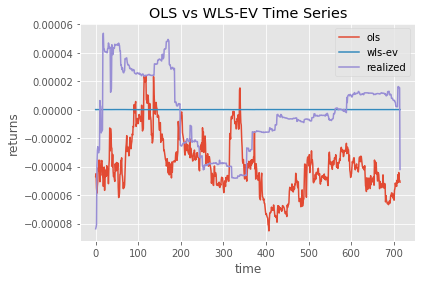

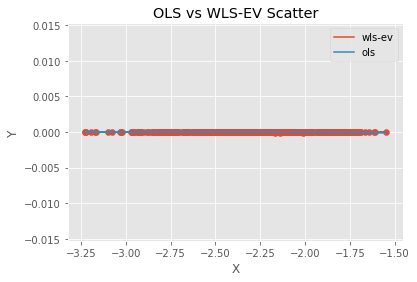

In [33]:
forecast_horizon = 182

# P_kurtosis_182 = f(Q_kurtosis_182) + error
print('P_kurtosis_182 = f(Q_kurtosis_182) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_182'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_182'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_skewness_365 = f(Q_skewness_365) + error
##### Problem: not enough data

P_skewness_365 = f(Q_skewness_365) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 365
-------------------------------------------------------------------------------------------------------
betas: [ -3.75000000e-06  -1.32000000e-06]
robust bse standard errors: [  4.25000000e-06   1.98000000e-06]
t-stats: [-0.88052997 -0.66941982]
In sample R_squared: -0.31961718
In sample R_squared of standardized regression: 0.00015756
Out of sample R_squared: 0.97112563
-------------------------------------------------------------------------------------------------------


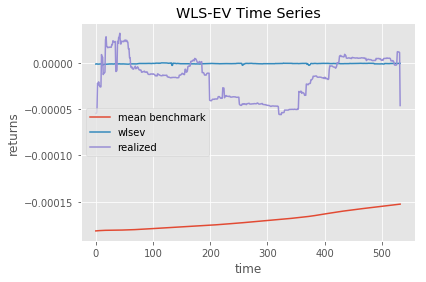

OLS Estimation Results
Forecast Horizon: 365
-------------------------------------------------------------------------------------------------------
betas: [ -1.60660000e-04  -1.58100000e-05]
robust bse standard errors: [  4.20300000e-05   1.94900000e-05]
t-stats: [-3.8222371  -0.81096877]
In sample R_squared: 0.00117064
Out of sample R_squared: -0.29881099
-------------------------------------------------------------------------------------------------------


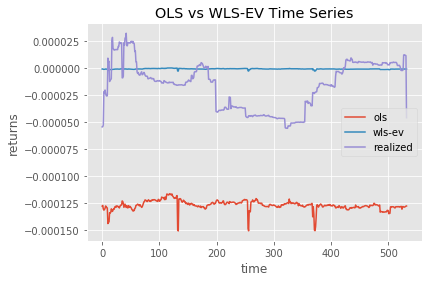

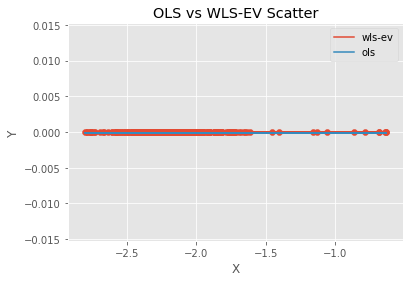

In [34]:
forecast_horizon = 365

# P_skewness_365 = f(Q_skewness_365) + error
print('P_skewness_365 = f(Q_skewness_365) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_skewness_365'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), data_pq_var['var_est_skewness1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_365'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### P_kurtosis_365 = f(Q_kurtosis_365) + error

P_kurtosis_365 = f(Q_kurtosis_365) + error
------------------------------------------------------------------------------------------------------------
WLS-EV Estimation Results
Forecast Horizon: 365
-------------------------------------------------------------------------------------------------------
betas: [  3.30000000e-07  -3.00000000e-08]
robust bse standard errors: [  4.40000000e-07  -4.00000000e-08]
t-stats: [ 0.7474901   0.79631061]
In sample R_squared: -0.33684517
In sample R_squared of standardized regression: -0.31449955
Out of sample R_squared: 0.98730191
-------------------------------------------------------------------------------------------------------


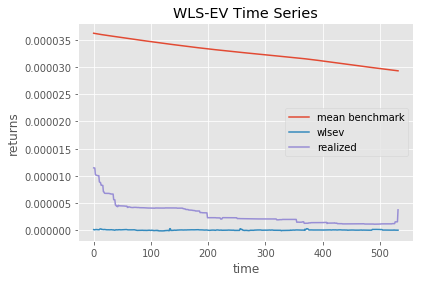

OLS Estimation Results
Forecast Horizon: 365
-------------------------------------------------------------------------------------------------------
betas: [ -1.60660000e-04  -1.58100000e-05]
robust bse standard errors: [  4.20300000e-05   1.94900000e-05]
t-stats: [-3.8222371  -0.81096877]
In sample R_squared: 0.00117064
Out of sample R_squared: -0.29881099
-------------------------------------------------------------------------------------------------------


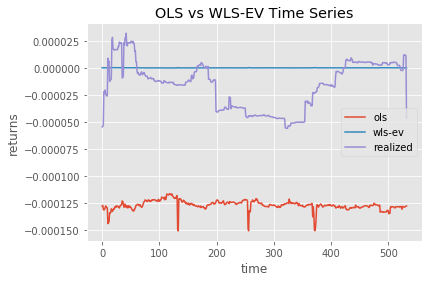

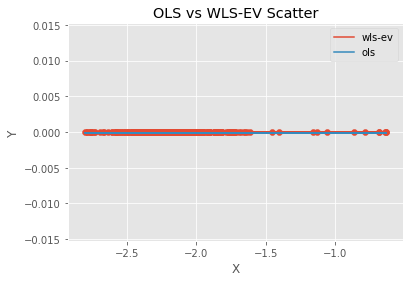

In [35]:
forecast_horizon = 365

# P_kurtosis_365 = f(Q_kurtosis_365) + error
print('P_kurtosis_365 = f(Q_kurtosis_365) + error')
print ('------------------------------------------------------------------------------------------------------------')
# WLS-EV
wlsev_obj = Wlsev_model(data_pq_var['Q_kurtosis_365'][:-1].as_matrix(), data_pq_var['kurtosis1'][1:].as_matrix(), data_pq_var['var_est_kurtosis1'][1:].as_matrix(), forecast_horizon)
wlsev_obj.fit()
# OOS evaluation to get Rsquared
wlsev_obj.evaluate()
wlsev_obj.print_results()
wlsev_obj.plot_results()
# get data
X, Y, y_wlsev = wlsev_obj.get_plot_data_wlsev()

# OLS
ols_obj = OLS_model(data_pq_var['Q_skewness_365'][:-1].as_matrix(), data_pq_var['skewness1'][1:].as_matrix(), forecast_horizon)
ols_obj.fit()
# OOS evaluation to get Rsquared
ols_obj.evaluate()
ols_obj.print_results()
# get data
X, Y, y_ols = ols_obj.get_plot_data_ols()

# time series plot
plot_results(X,Y,y_wlsev, y_ols)
# scatter plot
plot_scatter(X,Y,y_wlsev, y_ols)

### Regress Fama French Factors on Q-Moment